In [5]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from mpl_toolkits.mplot3d import Axes3D


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Exercise 1

### 1)

In [9]:
def simulate_sir_simple(lam, mu, I_0, T):
    """ why not take smaller step size????"""
    # initialize arrays for S, I, R
    S = np.zeros(T+1)
    I = np.zeros(T+1)
    R = np.zeros(T+1)
    # define odes for S, I, R
    def dS(S, I):
        return -lam*S*I
    def dI(S, I):
        return lam*S*I - mu*I
    def dR(I):
        return mu*I
    
    # initial conditions
    S[0] = 1 - I_0
    I[0] = I_0
    R[0] = 0

    # simulate the ODEs
    for t in range(T):
        S[t+1] = S[t] + dS(S[t], I[t])
        I[t+1] = I[t] + dI(S[t], I[t])
        R[t+1] = R[t] + dR(I[t])

    # calculate the daily changes
    delta_S = np.zeros(T)
    delta_R = np.zeros(T)
    for t in range(T):
        delta_S[t] = S[t] - S[t+1]
        delta_R[t] = R[t+1] - R[t]

    X = np.array([(delta_S[i], delta_R[i]) for i in range(T)])
    C = np.array([(S[i], I[i], R[i]) for i in range(T)])  #used for debugging and for part 1.2)
    return X

### 3)

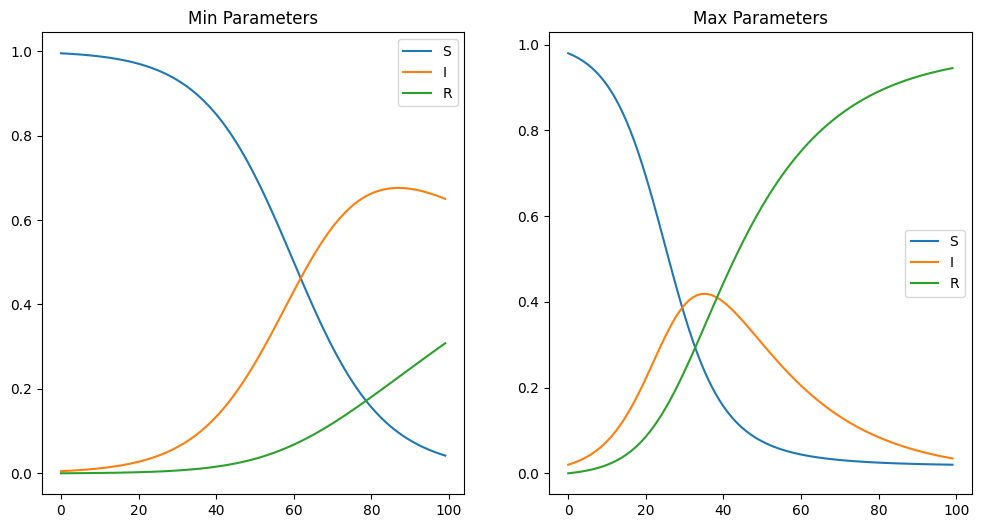

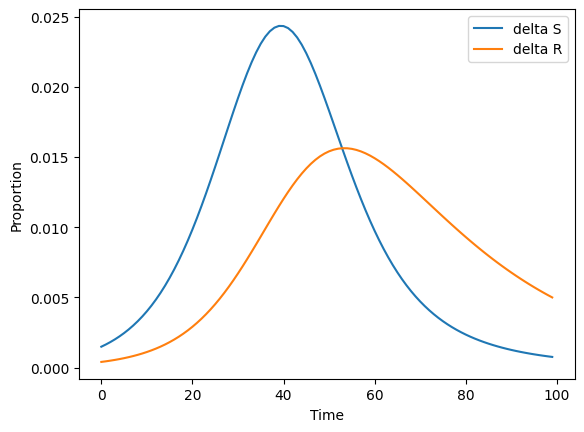

In [ ]:

"""THIS PART OF THE CODE IS ONLY NEEDED TO DEFINED PRIORS, AND NOT USED LATER.
 TO RUN IT, ADD C TO THE OUTPUT OF simulate_sir_simple"""
# plot the min and max parameters to see, for the later prior definition  (the C is removed from the function output, add to test new parameters)
def plot_sir(lam_min, lam_max, mu_min, mu_max, I0_min, I0_max, T=100):
    # simulate min parameters 
    _ , C_min = simulate_sir_simple(lam_min, mu_min, I0_min, T)

    # simulate max parameters
    _ , C_max = simulate_sir_simple(lam_max, mu_max, I0_max, T)

    # plot 
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].plot(C_min[:, 0], label='S')
    ax[0].plot(C_min[:, 1], label='I')
    ax[0].plot(C_min[:, 2], label='R')
    ax[0].set_title('Min Parameters')
    ax[0].legend()
    ax[1].plot(C_max[:, 0], label='S')
    ax[1].plot(C_max[:, 1], label='I')
    ax[1].plot(C_max[:, 2], label='R')
    ax[1].set_title('Max Parameters')
    ax[1].legend()
    plt.show()

plot_sir(0.1, 0.2, 0.01, 0.05, 0.005, 0.02)

# parameters 
lam = 0.15
mu = 0.04
I_0 = 0.01
T = 100

# simulate
X,_ = simulate_sir_simple(lam, mu, I_0, T)

plt.plot(X[:, 0], label='delta S')
plt.plot(X[:, 1], label='delta R')
plt.xlabel('Time')
plt.ylabel('Proportion')
plt.legend()
plt.show()

The plots show, that for lambda, mu and I_0, [0.1, 0.2], [0.01, 0.05], and [0.005, 0.02] are good parameter ranges.

In [7]:
# define the prior distribution for the simulation parameters 
def prior_distribution(num_samples):
    lam = np.random.uniform(0.1, 0.2, num_samples)
    mu = np.random.uniform(0.01, 0.05, num_samples)
    I_0 = np.random.uniform(0.005, 0.02, num_samples)
    return np.array(list(zip(lam, mu, I_0)))

### 3)

In [19]:
# define a feed forward neural network
class FeedForward(nn.Module):
    def __init__(self, input_size=200, hidden_size=64, num_layers=3, output_size=3):
        super(FeedForward, self).__init__()
        layers = []
        layer_size = input_size
        for i in range(num_layers):
            layers.append(nn.Linear(layer_size, hidden_size))
            layers.append(nn.ReLU())
            layer_size = hidden_size
        layers.append(nn.Linear(layer_size, output_size)) 
        self.network = nn.Sequential(*layers)  #bundle the layers together

    def forward(self, x):
        return self.network(x)
    

In [20]:
def train_feedforward(model, simulation, priors, epochs, lr, batch_size):
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # train the model
    for epoch in range(epochs):
        samples = priors(batch_size)
        X = np.array([simulation(*sample, 100) for sample in samples])
        X = torch.tensor(X, dtype=torch.float32).to(device)
        X = X.view(X.size(0), -1)  # Flatten the time and feature dimensions
        samples = torch.tensor(samples, dtype=torch.float32).to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward pass
        y_pred = model(X)
        # calculate the loss
        loss = loss_fn(y_pred, samples)
        # backward pass
        loss.backward()
        # optimize
        optimizer.step()
        # print the loss
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss {loss.item()}')

In [11]:
def evaluate(model, simulation, priors, epochs, batch_size):
    "nuber of samples in the test set is epochs*batch_size"
    loss_list = []
    loss_fn = nn.MSELoss()
    for epoch in range(epochs):
        samples = priors(batch_size)
        X = np.array([simulation(*sample, 100) for sample in samples])
        X = torch.tensor(X, dtype=torch.float32).to(device)
        X = X.view(X.size(0), -1)
        samples = torch.tensor(samples, dtype=torch.float32).to(device)
        
        with torch.no_grad():
            # forward pass
            y_pred = model(X)
            # calculate the loss
            loss = loss_fn(y_pred, samples)
            loss_list.append(loss.item())
    loss = np.mean(loss_list)
    return loss

In [12]:
hidden_size_list = [32, 64, 128, 256]
num_layers_list = [2, 5, 10]
epochs_list = [100, 1000, 5000, 10000]
batch_size_list = [32, 64]

In [22]:
# Parameter ranges
hidden_size_list = [32, 64, 128, 256]
num_layers_list = [2, 5, 10]
epochs_list = [100, 1000, 2000]
batch_size_list = [32, 64]

# Initialize lists for results
hidden_size_results = []
num_layers_results = []
epochs_results = []
batch_size_results = []

# Standard parameters
standard_hidden_size = 64
standard_num_layers = 5
standard_epochs = 200
standard_batch_size = 64
learning_rate = 0.01
device = "cpu"  # assuming CPU for training

# Vary hidden size
print("Varying Hidden Size:")
for hidden_size in hidden_size_list:
    model = FeedForward(100 * 2, hidden_size, standard_num_layers).to(device)
    train_feedforward(model, simulate_sir_simple, prior_distribution, standard_epochs, learning_rate, standard_batch_size)  	        
    loss = evaluate(model, simulate_sir_simple, prior_distribution, 10, standard_batch_size)    
    hidden_size_results.append(loss)

# Vary number of layers
print("Varying Number of Layers:")
for num_layers in num_layers_list:
    model = FeedForward(100 * 2, standard_hidden_size, num_layers).to(device)
    train_feedforward(model, simulate_sir_simple, prior_distribution, standard_epochs, learning_rate, standard_batch_size)
    loss = evaluate(model, simulate_sir_simple, prior_distribution, 10, standard_batch_size)
    num_layers_results.append(loss)

# Vary number of epochs
print("Varying Number of Epochs:")
for epochs in epochs_list:
    model = FeedForward(100 * 2, standard_hidden_size, standard_num_layers).to(device)
    train_feedforward(model, simulate_sir_simple, prior_distribution, epochs, learning_rate, standard_batch_size)
    loss = evaluate(model, simulate_sir_simple, prior_distribution, 10, standard_batch_size)
    epochs_results.append(loss)

# Vary batch size
print("Varying Batch Size:")
for batch_size in batch_size_list:
    model = FeedForward(100 * 2, standard_hidden_size, standard_num_layers).to(device)
    train_feedforward(model, simulate_sir_simple, prior_distribution, standard_epochs, learning_rate, batch_size)
    loss = evaluate(model, simulate_sir_simple, prior_distribution, 10, batch_size)
    batch_size_results.append(loss)

# Print results
print("\nHidden Size Results:", hidden_size_results)
print("\nNumber of Layers Results:", num_layers_results)
print("\nEpochs Results:", epochs_results)
print("\nBatch Size Results:", batch_size_results)

Varying Hidden Size:
Epoch 0, Loss 0.013485129922628403
Epoch 100, Loss 8.482272824039683e-05
Epoch 0, Loss 0.00848422572016716
Epoch 100, Loss 7.800975436111912e-05
Epoch 0, Loss 0.008423910476267338
Epoch 100, Loss 9.191737626679242e-05
Epoch 0, Loss 0.004397675860673189
Epoch 100, Loss 8.128394983941689e-05
Varying Number of Layers:
Epoch 0, Loss 0.026444265618920326
Epoch 100, Loss 6.947905785636976e-05
Epoch 0, Loss 0.03296404704451561
Epoch 100, Loss 0.0002457482914905995
Epoch 0, Loss 0.006563525181263685
Epoch 100, Loss 0.00032654497772455215
Varying Number of Epochs:
Epoch 0, Loss 0.021241774782538414
Epoch 0, Loss 0.013379485346376896
Epoch 100, Loss 0.00011745577648980543
Epoch 200, Loss 6.663386739091948e-05
Epoch 300, Loss 7.007570820860565e-05
Epoch 400, Loss 3.767992529901676e-05
Epoch 500, Loss 1.0908673175435979e-05
Epoch 600, Loss 8.555723979952745e-06
Epoch 700, Loss 5.0154017117165495e-06
Epoch 800, Loss 3.196178795406013e-06
Epoch 900, Loss 3.354123464305303e-06
Ep

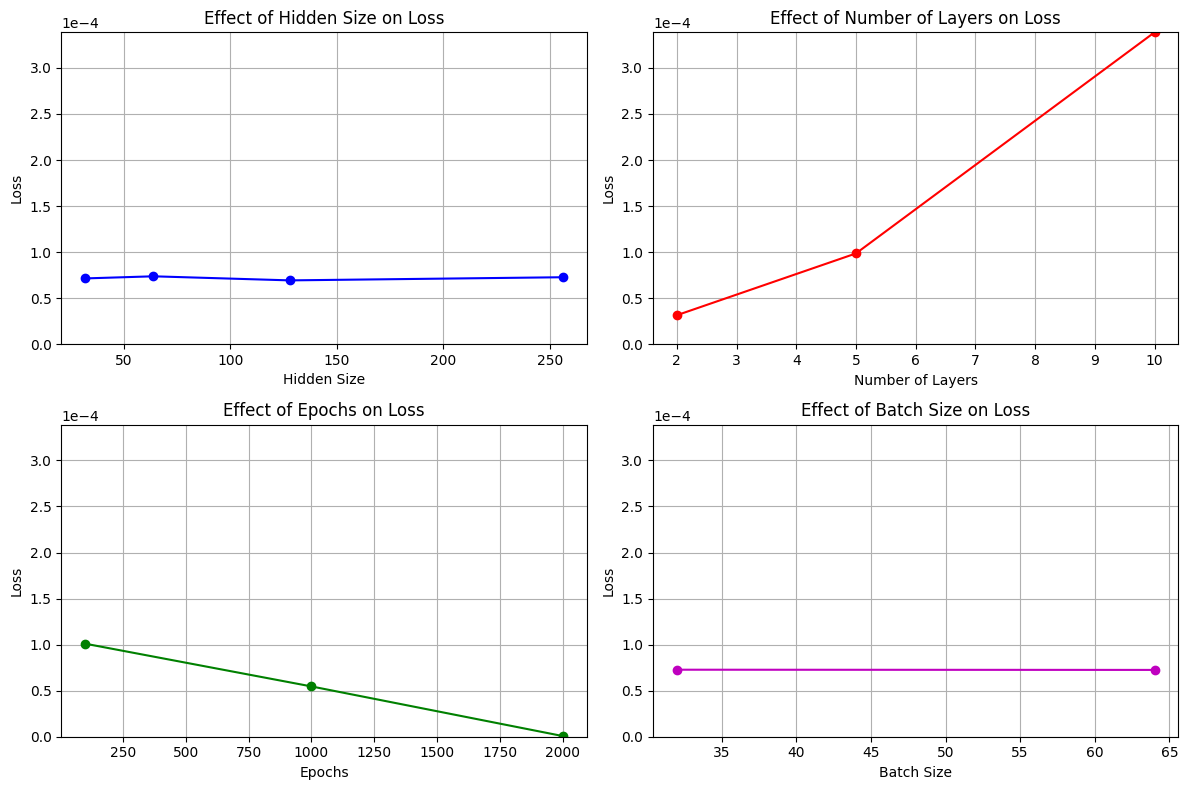

In [17]:
import matplotlib.pyplot as plt

# Set the ymin to 0 for all plots and use scientific notation for the y-axis
y_min = 0
y_max = max(max(hidden_size_results), max(num_layers_results), max(epochs_results), max(batch_size_results))

# Create a figure with 2 rows and 2 columns to place the plots next to each other
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot results for varying hidden size
axs[0, 0].plot(hidden_size_list, hidden_size_results, marker='o', color='b')
axs[0, 0].set_title('Effect of Hidden Size on Loss')
axs[0, 0].set_xlabel('Hidden Size')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].grid(True)
axs[0, 0].set_ylim(y_min, y_max)  # Set the same y-limits for all plots
axs[0, 0].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))  # Use scientific notation

# Plot results for varying number of layers
axs[0, 1].plot(num_layers_list, num_layers_results, marker='o', color='r')
axs[0, 1].set_title('Effect of Number of Layers on Loss')
axs[0, 1].set_xlabel('Number of Layers')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].grid(True)
axs[0, 1].set_ylim(y_min, y_max)  # Set the same y-limits for all plots
axs[0, 1].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))  # Use scientific notation

# Plot results for varying number of epochs
axs[1, 0].plot(epochs_list, epochs_results, marker='o', color='g')
axs[1, 0].set_title('Effect of Epochs on Loss')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].grid(True)
axs[1, 0].set_ylim(y_min, y_max)  # Set the same y-limits for all plots
axs[1, 0].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))  # Use scientific notation

# Plot results for varying batch size
axs[1, 1].plot(batch_size_list, batch_size_results, marker='o', color='m')
axs[1, 1].set_title('Effect of Batch Size on Loss')
axs[1, 1].set_xlabel('Batch Size')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].grid(True)
axs[1, 1].set_ylim(y_min, y_max)  # Set the same y-limits for all plots
axs[1, 1].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))  # Use scientific notation

# Adjust layout for better spacing
plt.tight_layout()

# Show all plots
plt.show()


Hidden_size and batch size seem to have no influence on test set loss. Increasing epochs (i.e. training set) is best way to minimize loss. 2 layers seem to be sufficient.

In [18]:
# Standard parameters set by best model
standard_hidden_size = 32
standard_num_layers = 2
standard_epochs = 2000
standard_batch_size = 64
learning_rate = 0.01
device = "cpu"  # assuming CPU for training

model = FeedForward(100 * 2, standard_hidden_size, standard_num_layers).to(device)
train_feedforward(model, simulate_sir_simple, prior_distribution, standard_epochs, learning_rate, standard_batch_size)
loss = evaluate(model, simulate_sir_simple, prior_distribution, 10, standard_batch_size)
print(f"Test set loss is: {loss}")


Epoch 0, Loss 0.0017881705425679684
Epoch 100, Loss 5.606481499853544e-05
Epoch 200, Loss 3.300209573353641e-05
Epoch 300, Loss 2.2593399990000762e-05
Epoch 400, Loss 2.988809865200892e-05
Epoch 500, Loss 1.61100961122429e-05
Epoch 600, Loss 1.1697250556608196e-05
Epoch 700, Loss 9.361521733808331e-06
Epoch 800, Loss 7.5642979027179535e-06
Epoch 900, Loss 6.492650300060632e-06
Epoch 1000, Loss 4.199331215204438e-06
Epoch 1100, Loss 5.09500250700512e-06
Epoch 1200, Loss 8.110565431707073e-06
Epoch 1300, Loss 3.7489055557671236e-06
Epoch 1400, Loss 3.5923897030443186e-06
Epoch 1500, Loss 3.6197304780216655e-06
Epoch 1600, Loss 3.348141035530716e-06
Epoch 1700, Loss 2.9036445994279347e-06
Epoch 1800, Loss 2.7385719931771746e-06
Epoch 1900, Loss 3.1645840863347985e-06
Test set loss is: 3.4932447988467174e-06


### 4)

In [33]:
# define a feed forward neural network removing the last layer for the feature detector

class FeatureDetector(nn.Module):
    def __init__(self, input_size=200, hidden_size=32, num_layers=2):  #optimal parameters found earlier
        super(FeatureDetector, self).__init__()
        layers = []
        layer_size = input_size
        for i in range(num_layers):
            layers.append(nn.Linear(layer_size, hidden_size))
            layers.append(nn.ReLU())
            layer_size = hidden_size
        self.network = nn.Sequential(*layers)  #bundle the layers together

    def forward(self, x):
        return self.network(x)


In [102]:
#defining conditional RealNVP
class CondRealNVP(nn.Module):
    def __init__(self, input_size, hidden_size, num_hidden_layers, blocks, condition_size, a=1):
        super(CondRealNVP, self).__init__()
        self.input_size = input_size
        self.condition_size = condition_size
        self.blocks = nn.ModuleList([
            CouplingBlock(input_size, hidden_size, num_hidden_layers, condition_size, a) for _ in range(blocks)
        ])
        self.rotations = [torch.qr(torch.randn(input_size, input_size))[0] for _ in range(blocks - 1)]
        self.a = a  # Scaling factor for exponent in affine transformation

    def forward(self, x, condition):
        log_det = 0
        for i, block in enumerate(self.blocks):
            x, ld = block.forward(x, condition)
            log_det += ld
            if i < len(self.rotations):
                x = x @ self.rotations[i]
        return x, log_det

    def inverse(self, z, condition):
        for i, block in reversed(list(enumerate(self.blocks))):
            if i < len(self.rotations):
                z = z @ self.rotations[i].T
            z = block.inverse(z, condition)
        return z

    def sample(self, num_samples, conditions):
        # 'conditions' is a tensor of size (num_samples, condition_size)
        z = torch.randn(num_samples, self.input_size)
        return self.inverse(z, conditions)


class CouplingBlock(nn.Module):
    def __init__(self, input_size, hidden_size, num_hidden_layers, condition_size, a=1):
        super(CouplingBlock, self).__init__()

        # Calculate split sizes
        self.split_size1 = input_size // 2  # Smaller part
        self.split_size2 = input_size - self.split_size1  # Larger part

        self.t_net = FeedForward(self.split_size1 + condition_size, hidden_size, num_hidden_layers, self.split_size2)  
        self.s_net = FeedForward(self.split_size1 + condition_size, hidden_size, num_hidden_layers, self.split_size2)
        self.a = a
    
    def forward(self, x, condition):
        x1 = x[:, :self.split_size1]  # Take the first part
        x2 = x[:, self.split_size1:]  # Take the rest

        input_conditioned = torch.cat([x1, condition], dim=1)        
        t = self.t_net(input_conditioned)
        s = self.s_net(input_conditioned)
        
        z1 = x1  # Identity transformation
        z2 = x2 * torch.exp(self.a * torch.tanh(s)) + t  # Affine transformation
        log_det = (self.a * torch.tanh(s)).sum(dim=1)
        
        return torch.cat([z1, z2], dim=1), log_det

    def inverse(self, z, condition):
        z1 = z[:, :self.split_size1]  # Take the first part
        z2 = z[:, self.split_size1:]  # Take the rest
    
        # Concatenate the condition to z1
        input_conditioned = torch.cat([z1, condition], dim=1)

        t = self.t_net(input_conditioned)
        s = self.s_net(input_conditioned)
        
        x1 = z1
        x2 = (z2 - t) * torch.exp(-self.a * torch.tanh(s))
        
        return torch.cat([x1, x2], dim=1)
    
def train_conditional_inn(CondRealNVPmodel, FeatureDetectormodel, simulation, priors, epochs, lr, batch_size):
    optimizer = torch.optim.Adam(
    list(CondRealNVPmodel.parameters()) + list(FeatureDetectormodel.parameters()),
    lr=lr)

    for epoch in range(epochs):
        CondRealNVPmodel.train()
        FeatureDetectormodel.train()    
        samples = priors(batch_size)
        X = np.array([simulation(*sample, 100) for sample in samples])
        X = torch.tensor(X, dtype=torch.float32).to(device)
        X = X.view(X.size(0), -1)  # Flatten the time and feature dimensions
        features = FeatureDetectormodel(X)
        samples = torch.tensor(samples, dtype=torch.float32).to(device)

        z, log_det = CondRealNVPmodel(samples, features)
        log_prob = -0.5 * (z ** 2).sum(dim=1)  # Log of the Gaussian
        loss = -(log_prob + log_det).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")


In [294]:
h_model = FeatureDetector(200, 64, 10).to(device) #(input_size, hidden_size, num_layers)
cNF = CondRealNVP(3, 64, 3, 10, 64).to(device) #(input_size, hidden_size, num_hidden_layers, blocks, condition_size)

train_conditional_inn(cNF, h_model, simulate_sir_simple, prior_distribution, 1000, 0.0001, 128)

Epoch 1/1000, Loss: -0.2638
Epoch 2/1000, Loss: -0.2897
Epoch 3/1000, Loss: -0.3128
Epoch 4/1000, Loss: -0.3341
Epoch 5/1000, Loss: -0.3618
Epoch 6/1000, Loss: -0.3824
Epoch 7/1000, Loss: -0.4055
Epoch 8/1000, Loss: -0.4285
Epoch 9/1000, Loss: -0.4543
Epoch 10/1000, Loss: -0.4727
Epoch 11/1000, Loss: -0.4982
Epoch 12/1000, Loss: -0.5197
Epoch 13/1000, Loss: -0.5440
Epoch 14/1000, Loss: -0.5667
Epoch 15/1000, Loss: -0.5880
Epoch 16/1000, Loss: -0.6093
Epoch 17/1000, Loss: -0.6309
Epoch 18/1000, Loss: -0.6530
Epoch 19/1000, Loss: -0.6771
Epoch 20/1000, Loss: -0.6976
Epoch 21/1000, Loss: -0.7206
Epoch 22/1000, Loss: -0.7419
Epoch 23/1000, Loss: -0.7628
Epoch 24/1000, Loss: -0.7830
Epoch 25/1000, Loss: -0.8064
Epoch 26/1000, Loss: -0.8275
Epoch 27/1000, Loss: -0.8502
Epoch 28/1000, Loss: -0.8714
Epoch 29/1000, Loss: -0.8913
Epoch 30/1000, Loss: -0.9135
Epoch 31/1000, Loss: -0.9343
Epoch 32/1000, Loss: -0.9544
Epoch 33/1000, Loss: -0.9777
Epoch 34/1000, Loss: -0.9974
Epoch 35/1000, Loss: -1

Average MSE Loss: 0.0002889990


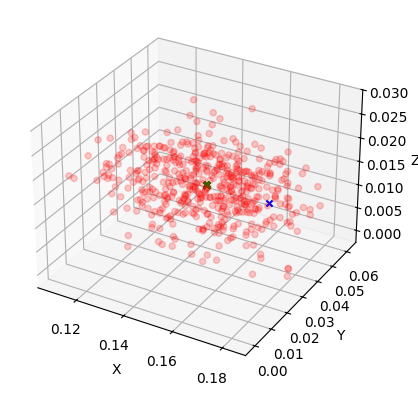

In [311]:
samples = prior_distribution(1) #some representative samples for evaluation
cNF.eval()
h_model.eval()

X = np.array([simulate_sir_simple(*sample, 100) for sample in samples])
X = torch.tensor(X, dtype=torch.float32).to(device)
X = X.view(X.size(0), -1)  # Flatten the time and feature dimensions
features = h_model(X)
features = features.repeat(500, 1)

z = torch.randn(500, 3) #generate 10 latent codes from a gaussian 
z0 = torch.zeros(500,3)
y_pred = cNF.inverse(z, features).detach().numpy()
y_pred0 = cNF.inverse(z0, features).detach().numpy()

# Compute average MSE loss
samples_expanded = np.repeat(samples, 500, axis=0)  # Expand ground-truth to match `y_pred`
mse_loss = np.mean((y_pred - samples_expanded) ** 2)
print(f"Average MSE Loss: {mse_loss:.10f}")

# Plot in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(y_pred[:,0], y_pred[:,1], y_pred[:,2], alpha=0.2, c='r', marker='o')
ax.scatter(samples[:,0], samples[:,1], samples[:,2], c='b', marker='x')
ax.scatter(y_pred0[:,0], y_pred0[:,1], y_pred0[:,2], c='g', marker='x')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

Groundtrouth in blue, generated samples in red. In green, the point generated by the code z=(0,0,0). We sampled codes from code distribution. To sample codes accordingly to distribution in real space, sampling weighted by probability using the log-det would have to be done. This was done in the next cell.

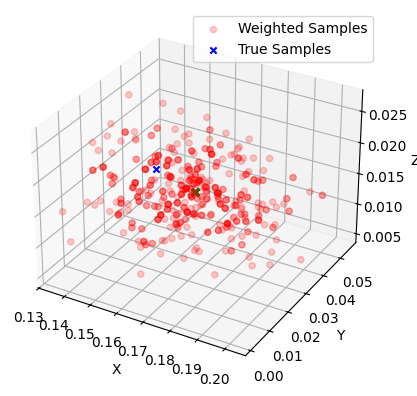

In [318]:
samples = prior_distribution(1)  # Some representative samples for evaluation
cNF.eval()
h_model.eval()

# Simulate features
X = np.array([simulate_sir_simple(*sample, 100) for sample in samples])
X = torch.tensor(X, dtype=torch.float32).to(device)
X = X.view(X.size(0), -1)  # Flatten the time and feature dimensions
features = h_model(X)
features = features.repeat(500, 1)

# Generate latent samples and corresponding real samples
z = torch.randn(500, 3)  # Generate latent codes from a Gaussian
y_pred = cNF.inverse(z, features).detach()
z0 = torch.zeros(500,3)
y_pred0 = cNF.inverse(z0, features).detach().numpy()


# Compute log-probabilities for the samples in real space
log_det = torch.zeros(500)
for i in range(500):
    _, log_det[i] = cNF.forward(y_pred[i].unsqueeze(0), features[i].unsqueeze(0))

log_prob_real = -0.5 * (z ** 2).sum(dim=1) + log_det  # Real-space log-probabilities

# Convert to normalized weights
weights = torch.exp(log_prob_real - log_prob_real.max())  # Avoid numerical issues
weights /= weights.sum()

# Perform weighted sampling
weighted_indices = torch.multinomial(weights, num_samples=500, replacement=True)
y_weighted = y_pred[weighted_indices].detach().numpy()

# Plot results in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(y_weighted[:, 0], y_weighted[:, 1], y_weighted[:, 2], alpha=0.2, c='r', marker='o', label="Weighted Samples")
ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2], c='b', marker='x', label="True Samples")
ax.scatter(y_pred0[:,0], y_pred0[:,1], y_pred0[:,2], c='g', marker='x')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.legend()
plt.show()


Weighing the samples causes the samples to be closer to the ground trouth (blue), albeit still not perfect.